In [1]:
!pip install -q datasets ipywidgets
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./cats_vs_dogs")
dataset = dataset["train"]
dataset

Resolving data files:   0%|          | 0/1877 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 1877
})

In [2]:
dataset = dataset.shuffle(seed=1234).select(range(200)) # 🤔
dataset = dataset.train_test_split(test_size=0.3, seed=1234)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 140
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 60
    })
})

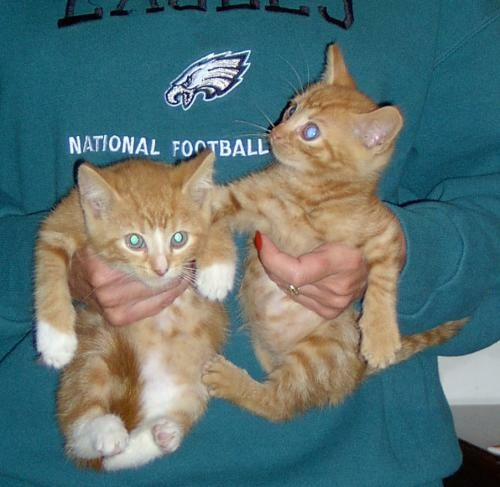

In [3]:
!pip install -q Pillow

dataset["train"][0]["image"]

In [4]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = int(i)
    id2label[str(i)] = label

id2label

{'0': 'cat', '1': 'dog'}

In [5]:
!pip install -q torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers accelerate

from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor # 🤔

checkpoint = "google/vit-base-patch16-224-in21k" # 🤔
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize]) # 🤔

def transform(examples):
    examples["pixel_values"] = [transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transform)
transformed_dataset

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 140
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 60
    })
})

In [6]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [7]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0

    for _, param in model.named_parameters():
      all_param += param.numel()

      if param.requires_grad:
        trainable_params += param.numel()

    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}")

print_trainable_parameters(model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [8]:
!pip install -q peft

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    target_modules=["query", "value"],
    modules_to_save=["classifier"],
    # r=8,
    # lora_alpha=8,
    # lora_dropout=0.1,
)

lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 296450 || all params: 86096644 || trainable%: 0.34


In [9]:
!pip install -q evaluate scikit-learn

from transformers import TrainingArguments, Trainer, DefaultDataCollator

import torch
import evaluate
import numpy as np

training_args = TrainingArguments(
    output_dir="my_image_lora_model", # 🤔
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch", # 🤔
    learning_rate=3e-4, # 🤔
    per_device_train_batch_size=10, # 🤔
    gradient_accumulation_steps=1, # 🤔
    per_device_eval_batch_size=10, # 🤔
    num_train_epochs=30, # 🤔
    warmup_ratio=0.1, # 🤔
    # logging_steps=10, # 🤔
    # load_best_model_at_end=True, # 🤔
    # metric_for_best_model="accuracy",
    bf16=True,
    label_names=["labels"],
)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

OUTPUT_PATH = "./my_final_image_lora_model"

trainer.train()
trainer.save_model(OUTPUT_PATH) # 🤔

  0%|          | 0/420 [00:00<?, ?it/s]

c:\Users\Sarach\WS\KU\Courses\262 ML Sys\67-1\Code\lab\venv\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.6744140982627869, 'eval_accuracy': 0.65, 'eval_runtime': 0.3981, 'eval_samples_per_second': 150.729, 'eval_steps_per_second': 15.073, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.6222006678581238, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 0.3862, 'eval_samples_per_second': 155.343, 'eval_steps_per_second': 15.534, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.5196288824081421, 'eval_accuracy': 1.0, 'eval_runtime': 0.3932, 'eval_samples_per_second': 152.583, 'eval_steps_per_second': 15.258, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.38828128576278687, 'eval_accuracy': 1.0, 'eval_runtime': 0.3929, 'eval_samples_per_second': 152.706, 'eval_steps_per_second': 15.271, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.23955890536308289, 'eval_accuracy': 1.0, 'eval_runtime': 0.3853, 'eval_samples_per_second': 155.712, 'eval_steps_per_second': 15.571, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.13280029594898224, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.3791, 'eval_samples_per_second': 158.251, 'eval_steps_per_second': 15.825, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.07382813841104507, 'eval_accuracy': 1.0, 'eval_runtime': 0.3717, 'eval_samples_per_second': 161.434, 'eval_steps_per_second': 16.143, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.04445088654756546, 'eval_accuracy': 1.0, 'eval_runtime': 0.3866, 'eval_samples_per_second': 155.198, 'eval_steps_per_second': 15.52, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02513936348259449, 'eval_accuracy': 1.0, 'eval_runtime': 0.4026, 'eval_samples_per_second': 149.039, 'eval_steps_per_second': 14.904, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.028310144320130348, 'eval_accuracy': 1.0, 'eval_runtime': 0.3901, 'eval_samples_per_second': 153.808, 'eval_steps_per_second': 15.381, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.05625609681010246, 'eval_accuracy': 0.9666666666666667, 'eval_runtime': 0.3944, 'eval_samples_per_second': 152.145, 'eval_steps_per_second': 15.214, 'epoch': 11.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02618866041302681, 'eval_accuracy': 1.0, 'eval_runtime': 0.398, 'eval_samples_per_second': 150.75, 'eval_steps_per_second': 15.075, 'epoch': 12.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.05056609958410263, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.381, 'eval_samples_per_second': 157.46, 'eval_steps_per_second': 15.746, 'epoch': 13.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02398325689136982, 'eval_accuracy': 1.0, 'eval_runtime': 0.4023, 'eval_samples_per_second': 149.13, 'eval_steps_per_second': 14.913, 'epoch': 14.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.03355204313993454, 'eval_accuracy': 1.0, 'eval_runtime': 0.4264, 'eval_samples_per_second': 140.704, 'eval_steps_per_second': 14.07, 'epoch': 15.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.01263402123004198, 'eval_accuracy': 1.0, 'eval_runtime': 0.4273, 'eval_samples_per_second': 140.408, 'eval_steps_per_second': 14.041, 'epoch': 16.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02497660554945469, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.4105, 'eval_samples_per_second': 146.173, 'eval_steps_per_second': 14.617, 'epoch': 17.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.07425208389759064, 'eval_accuracy': 0.9666666666666667, 'eval_runtime': 0.4274, 'eval_samples_per_second': 140.379, 'eval_steps_per_second': 14.038, 'epoch': 18.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.10836232453584671, 'eval_accuracy': 0.9666666666666667, 'eval_runtime': 0.5302, 'eval_samples_per_second': 113.174, 'eval_steps_per_second': 11.317, 'epoch': 19.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.049617521464824677, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.5352, 'eval_samples_per_second': 112.117, 'eval_steps_per_second': 11.212, 'epoch': 20.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.06893666088581085, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.4969, 'eval_samples_per_second': 120.753, 'eval_steps_per_second': 12.075, 'epoch': 21.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.03293253481388092, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.4747, 'eval_samples_per_second': 126.406, 'eval_steps_per_second': 12.641, 'epoch': 22.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.010252377949655056, 'eval_accuracy': 1.0, 'eval_runtime': 0.5169, 'eval_samples_per_second': 116.085, 'eval_steps_per_second': 11.609, 'epoch': 23.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.0625963881611824, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.5368, 'eval_samples_per_second': 111.783, 'eval_steps_per_second': 11.178, 'epoch': 24.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.04285126179456711, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.5626, 'eval_samples_per_second': 106.65, 'eval_steps_per_second': 10.665, 'epoch': 25.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.01982065849006176, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.5537, 'eval_samples_per_second': 108.369, 'eval_steps_per_second': 10.837, 'epoch': 26.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02669779770076275, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.486, 'eval_samples_per_second': 123.451, 'eval_steps_per_second': 12.345, 'epoch': 27.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.02397003211081028, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 0.5104, 'eval_samples_per_second': 117.546, 'eval_steps_per_second': 11.755, 'epoch': 28.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.07238082587718964, 'eval_accuracy': 0.9833333333333333, 'eval_runtime': 1.2051, 'eval_samples_per_second': 49.787, 'eval_steps_per_second': 4.979, 'epoch': 29.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.01382675115019083, 'eval_accuracy': 1.0, 'eval_runtime': 0.8143, 'eval_samples_per_second': 73.679, 'eval_steps_per_second': 7.368, 'epoch': 30.0}
{'train_runtime': 80.1437, 'train_samples_per_second': 52.406, 'train_steps_per_second': 5.241, 'train_loss': 0.11635955628894624, 'epoch': 30.0}


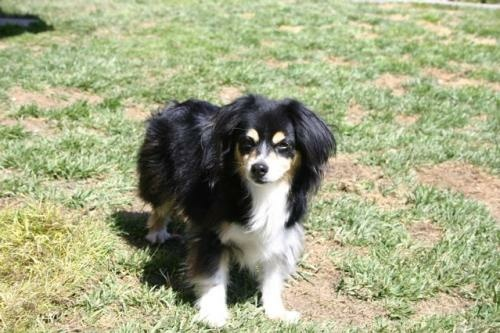

In [10]:
image = dataset["test"]["image"][0] # 🤔
image

In [11]:
from transformers import pipeline

classifier = pipeline("image-classification", model=OUTPUT_PATH, device="cuda")
classifier(image)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


[{'label': 'LABEL_0', 'score': 0.5219225883483887},
 {'label': 'LABEL_1', 'score': 0.47807741165161133}]

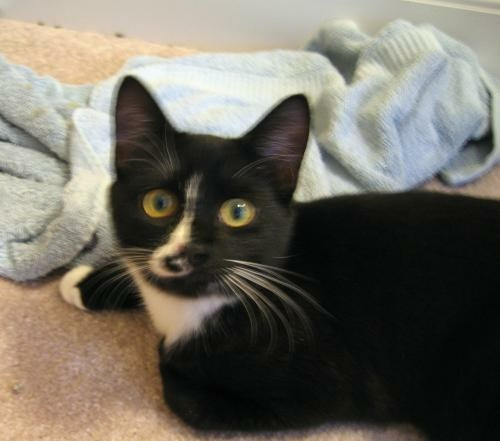

In [12]:
image = dataset["test"]["image"][1] # 🤔
image

In [13]:
classifier(image)

[{'label': 'LABEL_1', 'score': 0.5202775001525879},
 {'label': 'LABEL_0', 'score': 0.4797224998474121}]